# Capstone 2 -- Modeling

## Introduction
This is notebook is notebook 4 of Springboard Capstone 2 covering modeling and model evaluation.  The previous notebooks covered 1. Data Wrangling, 2. EDA, and 3. Preprocessing and Training Development.
<br><br>
**The Data**<br>
The Data is derived from the [Online Retail II](https://archive.ics.uci.edu/dataset/502/online+retail+ii) dataset from the UCI machine learning repository.  The original dataset was a collection of all online transations from a UK based retail company from 01/12/2009 to 09/12/2011. 
<br><br>
The data was was cleaned to remove all cancelled orders, any duplicates and other miscelaneous items that needed cleaning.  The data was then split into two dataframes, one with known customers and one with unknown customers.  The unknown customer data was set aside and the known customer data was grouped by customer and transformed into a Recency, Frequency, Monetary (RFM) dataset.   
<br>
In addition to basic RFM data, the rfm data was expanded by calculating Average Order Value, Customer Lifetime, and Customer Lifetime Value.  This expanded rfm dataset will be used for comparison of models.
<br><br>
**The Goal** <br>
The goal with this project is to find the distinct customer segments to to allow the company to better focus on marketing strategies for each segment. 


## Imports and Default Settings

**Import Packages**

In [230]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

**Set Default Preferences**

In [232]:
# display all columns
pd.set_option('display.max_columns', None)

# surpress scientific notation
pd.options.display.float_format = '{:}'.format

# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

**Import Data** <br>
The models will be using two similar but seperate dataframes.  'rfm' contains Recency, Frequency, Monetary calculations derived from known customers in the online retail II dataset.  'rfm_expanded' contains the same Recency, Frequency, and Monetary valuse as well as Average Order Value, Customer Lifespan, and Customer Lifetime Value

In the previous notebook, two dataframes, 'rfm" and 'rfm_expanded' were normalized and scaled using sklearn packages PowerTransforemer and Standart Scaler to correct for skew and different magnituded in the data.

In [234]:
# import rfm_scaled_df as rfm_train
rfm_scaled = pd.read_csv('../Data/rfm_scaled_df.csv', dtype='float32', index_col='Customer ID')
rfm_scaled.info()


<class 'pandas.core.frame.DataFrame'>
Index: 5878 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    5878 non-null   float32
 1   Frequency  5878 non-null   float32
 2   Monetary   5878 non-null   float32
dtypes: float32(3)
memory usage: 91.8 KB


In [235]:
# import rfm_expanded_scaled_df as rfm_expanded_scaled
rfm_expanded_scaled = pd.read_csv('../Data/rfm_expanded_scaled_df.csv', dtype='float32', index_col='Customer ID')
rfm_expanded_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5878 entries, 12346.0 to 18287.0
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Recency    5878 non-null   float32
 1   Frequency  5878 non-null   float32
 2   Monetary   5878 non-null   float32
 3   AOV        5878 non-null   float32
 4   Lifespan   5878 non-null   float32
 5   CLV        5878 non-null   float32
dtypes: float32(6)
memory usage: 160.7 KB


## Model 1 - Basic RFM data
Model one will be rfm values only.

**Finding K for k-means**<br>
I will use the elbow method and the silhouette score to find the optimal k for the KMeans clustering.

k=1, inertia: 17633.9961
k=2, inertia: 8293.8320, change: -0.5296680351318908
k=3, inertia: 6161.2598, change: -0.65060331572781
k=4, inertia: 4683.2812, change: -0.734417472641956
k=5, inertia: 3914.2285, change: -0.7780294100772589
k=6, inertia: 3408.5740, change: -0.8067043932363424
k=7, inertia: 3054.9949, change: -0.8267553844967872
k=8, inertia: 2768.2458, change: -0.8430165326740363
k=9, inertia: 2509.3599, change: -0.8576976058098006


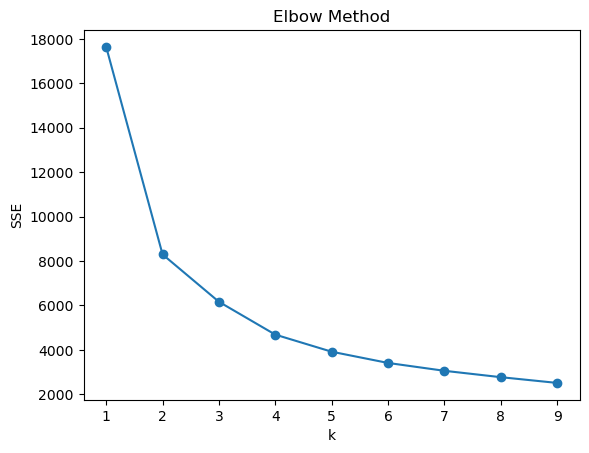

In [238]:
# create empty list for sum of squares values
inertia = []
k_values = range(1,10)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=25)
    kmeans.fit(rfm_scaled)
    
    # inertia_ for elbow method
    inertia.append(kmeans.inertia_)
    if k==1:
        print(f'k={k}, inertia: {inertia[-1]:.4f}')
    else:
        print(f"k={k}, inertia: {inertia[-1]:.4f}, change: {(inertia[-1]-inertia[0])/inertia[0]}")
    # print(inertia)
    
# plot elbow plot
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(k_values, inertia, marker='o')    
plt.show()

Based on the elbow method, a k of 3 would likely be optimal but a k of 4 could also be used .  Next I will check the silhouette_score to better decide which k to use.

In [240]:
k_values = range(2,10)
silhouette_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=25)
    labels = kmeans.fit_predict(rfm_scaled)  # Assign cluster labels
    score = silhouette_score(rfm_scaled, labels)
    silhouette_scores.append(score)
    print(f'k={k}, Silhouette Score: {score:.4f}')
    # print(labels)

k=2, Silhouette Score: 0.4352
k=3, Silhouette Score: 0.3429
k=4, Silhouette Score: 0.3790
k=5, Silhouette Score: 0.3442
k=6, Silhouette Score: 0.3418
k=7, Silhouette Score: 0.3216
k=8, Silhouette Score: 0.3062
k=9, Silhouette Score: 0.3063


The silhouette_scores suggests k=2 is the best seperation of the clusters.  This possibly could be a seperation between wholseale and non wholesale customers.  However, combined with the elbow method and the business goal of customer segmentation a k=2 might be too broad for customer segmentation purposes.  A k=4 has the next highest silhouette_score and is indicated by th elbow method as a possible optimal k measure.

Based on the silhouette_score,  the k values between 3 and 6 are all relatively close in clustering power.  Depending on how deep the company wanted to go into segmentation they would all be potential options for marketing.  Lacking the domain knowledge about this data taken from the internet and without guidance from managers in the company, I would pick a k=4 for this data based on the previous results. 

That being said, I will do a PCA to show the clusterings based on k=2 through k=6 below to visualize.

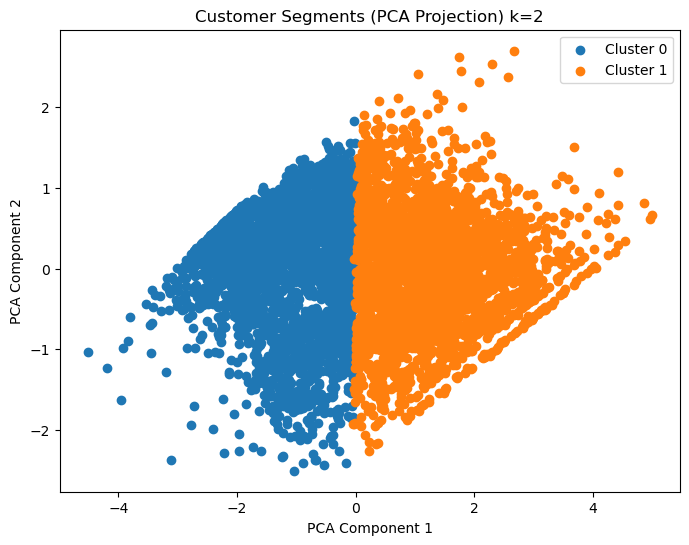

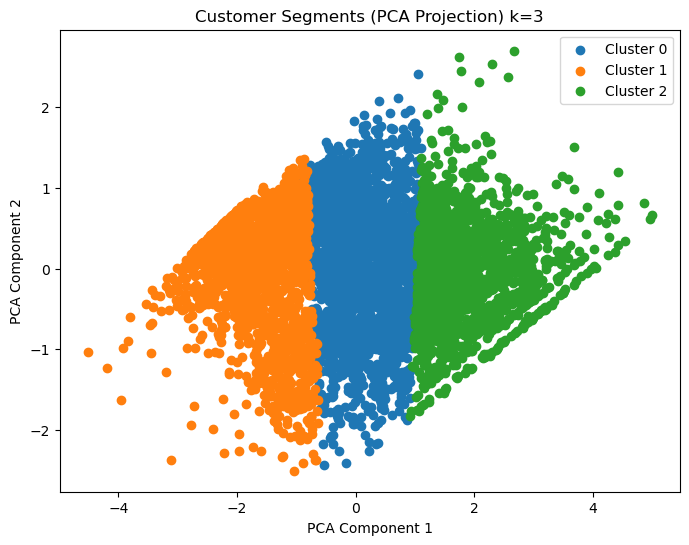

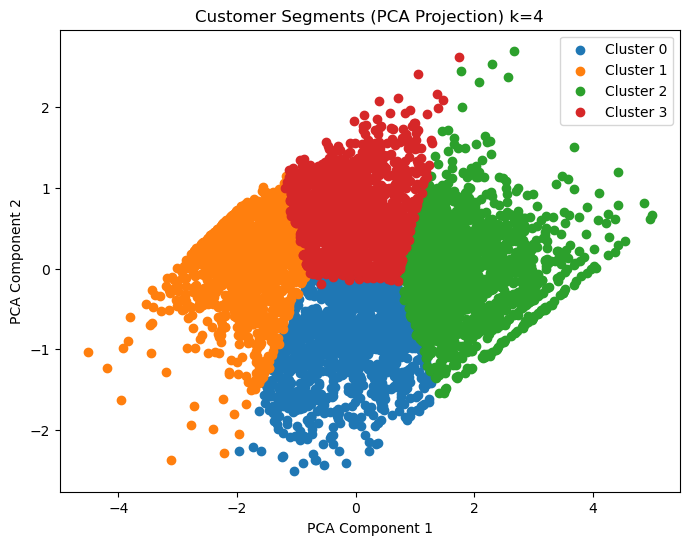

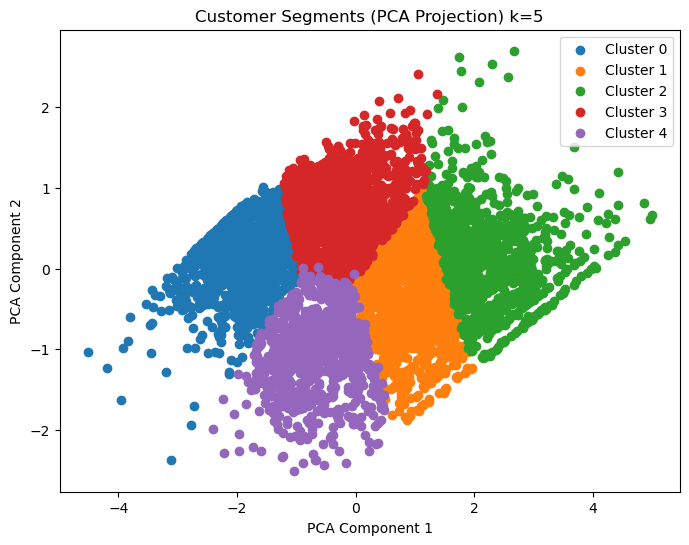

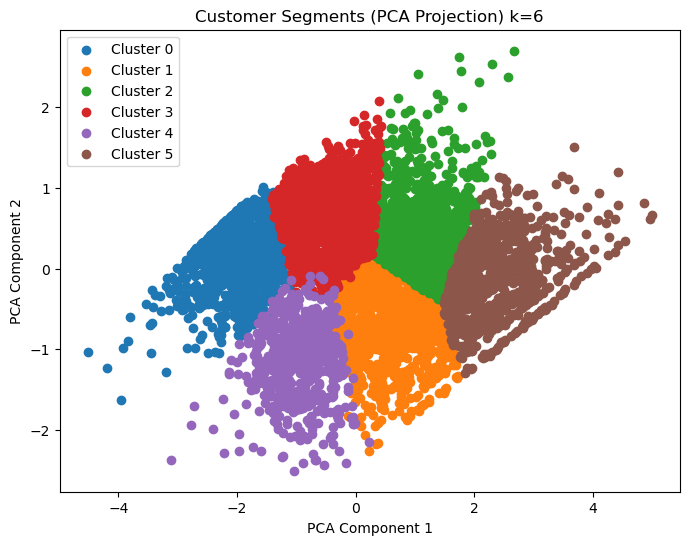

In [242]:

for k in range(2,7):
    k = k  
    kmeans = KMeans(n_clusters=k, random_state=25)
    labels = kmeans.fit_predict(rfm_scaled)
    
    # Reduce dimensions to 2 using PCA
    pca = PCA(n_components=2)
    rfm_pca = pca.fit_transform(rfm_scaled)
    
    # Scatter plot
    plt.figure(figsize=(8, 6))
    for cluster in range(k):
        plt.scatter(rfm_pca[labels == cluster, 0], rfm_pca[labels == cluster, 1], label=f'Cluster {cluster}')
    
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(f"Customer Segments (PCA Projection) k={k}")
    plt.legend()
    plt.show()


Run KMeans with k=4 and attach labels to dataset

In [244]:
kmeans= KMeans(n_clusters=4, random_state=25)
labels= kmeans.fit_predict(rfm_scaled)
rfm_scaled['Cluster'] = labels
rfm_scaled['Cluster'].value_counts()

Cluster
2    1680
1    1558
3    1402
0    1238
Name: count, dtype: int64

## Model 2 - RFM expanded data
Model two will be rfm values plus average order value (AOV) and customer lifetime value (CLV).

The same process will be followed for model 2 as with model 1.  

In [246]:
rfm_expanded_scaled.columns

Index(['Recency', 'Frequency', 'Monetary', 'AOV', 'Lifespan', 'CLV'], dtype='object')

**Repeat elbow and silhouette_scores**

k=1, inertia: 35268.0000
k=2, inertia: 23217.5957, change: -0.3416809656593796
k=3, inertia: 18595.5547, change: -0.4727357749943291
k=4, inertia: 15961.0576, change: -0.547435136180461
k=5, inertia: 14116.3994, change: -0.59973915691101
k=6, inertia: 12823.2109, change: -0.6364066310111149
k=7, inertia: 11899.4355, change: -0.6625996499128105
k=8, inertia: 11040.6953, change: -0.6869486414738574
k=9, inertia: 10207.4590, change: -0.7105744872299251


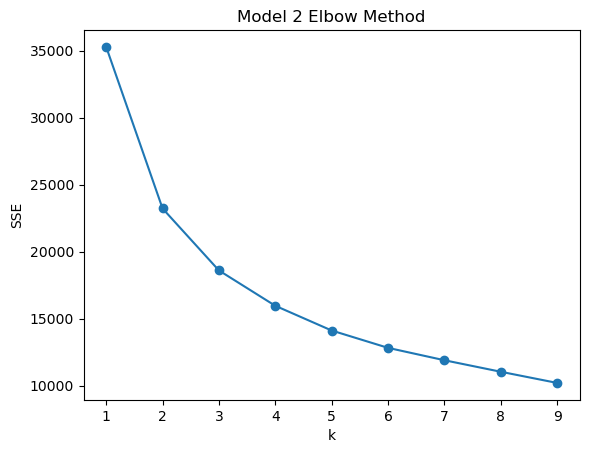

In [258]:
# create list for inertia values
inertia2 = []
k_values = range(1,10)

for k in k_values:
    kmeans = KMeans(n_clusters= k, random_state = 25)
    kmeans.fit(rfm_expanded_scaled)

    # inertia for elbow method and change 
    inertia2.append(kmeans.inertia_)
    if k==1:
        print(f'k={k}, inertia: {inertia2[-1]:.4f}')
    else:
        print(f"k={k}, inertia: {inertia2[-1]:.4f}, change: {(inertia2[-1]-inertia2[0])/inertia2[0]}")

# Plot elbow
plt.plot(k_values, inertia2, marker ='o')
plt.title('Model 2 Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.show()    


Including the additional values makes the the elbow less clear than with the previus model.  It also indicates k=2 or k=3 might be a better option for this data. We'll look at silhouette_score next to get clarity.

In [ ]:
# k_values = range(2,10)
# silhouette_scores = []

# for k in k_values:
#     kmeans = KMeans(n_clusters=k, random_state=25)
#     labels = kmeans.fit_predict(rfm_scaled)  # Assign cluster labels
#     score = silhouette_score(rfm_scaled, labels)
#     silhouette_scores.append(score)
#     print(f'k={k}, Silhouette Score: {score:.4f}')
#     # print(labels)

In [267]:
k_values= range(2,10)
silhouette_scores2 = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=25)
    labels = kmeans.fit_predict(rfm_expanded_scaled)
    score = silhouette_score(rfm_expanded_scaled, labels)
    silhouette_scores2.append(score)
    print(f'k={k}, Silhouette Score: {score:.4f}')

k=2, Silhouette Score: 0.3054
k=3, Silhouette Score: 0.3109
k=4, Silhouette Score: 0.2411
k=5, Silhouette Score: 0.2307
k=6, Silhouette Score: 0.2377
k=7, Silhouette Score: 0.2466
k=8, Silhouette Score: 0.2390
k=9, Silhouette Score: 0.2337


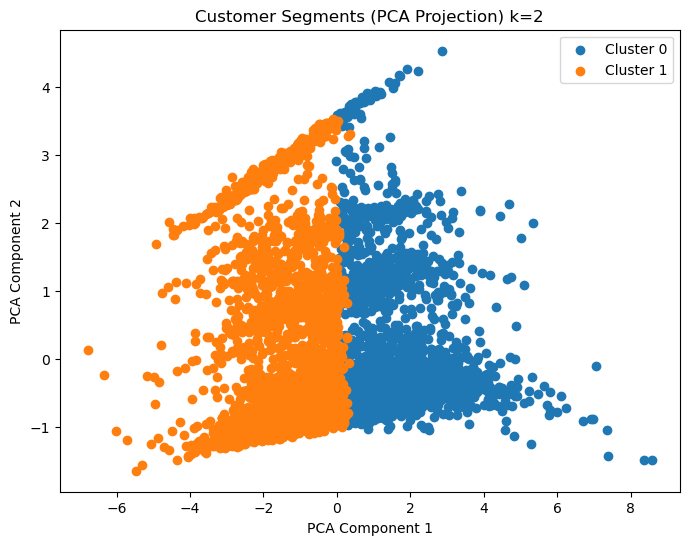

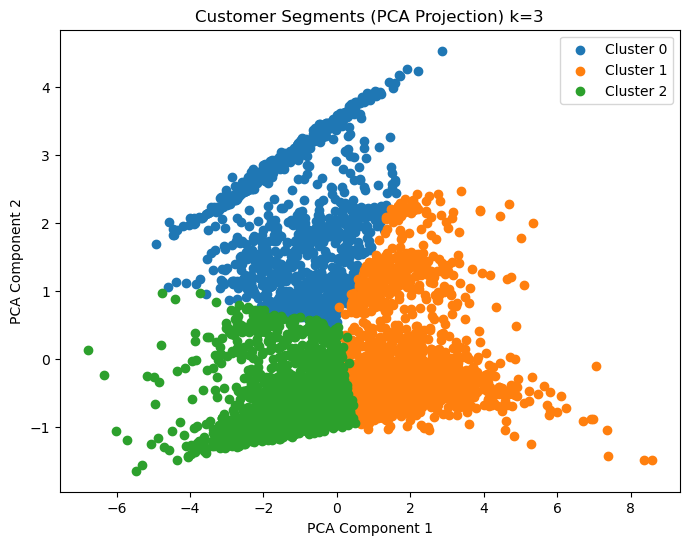

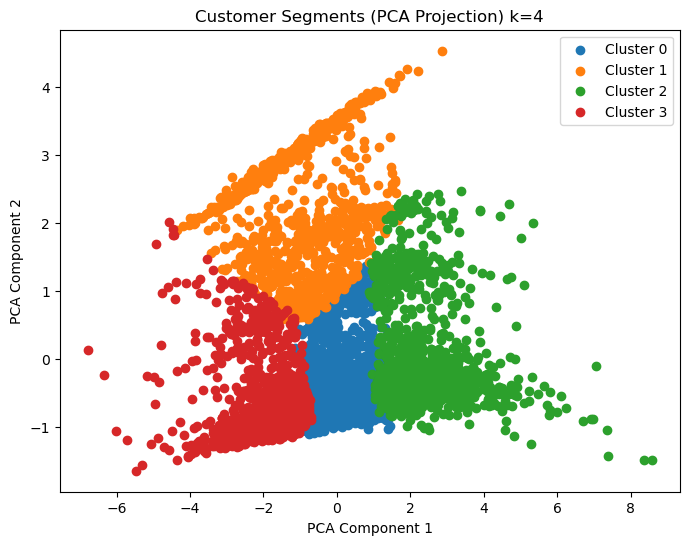

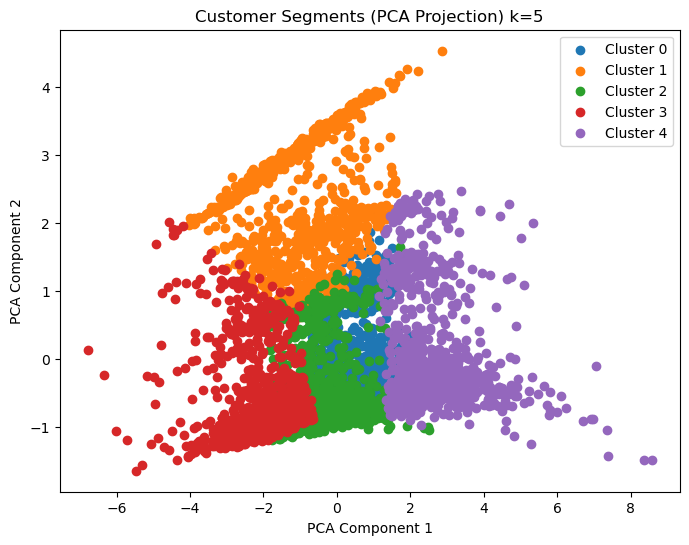

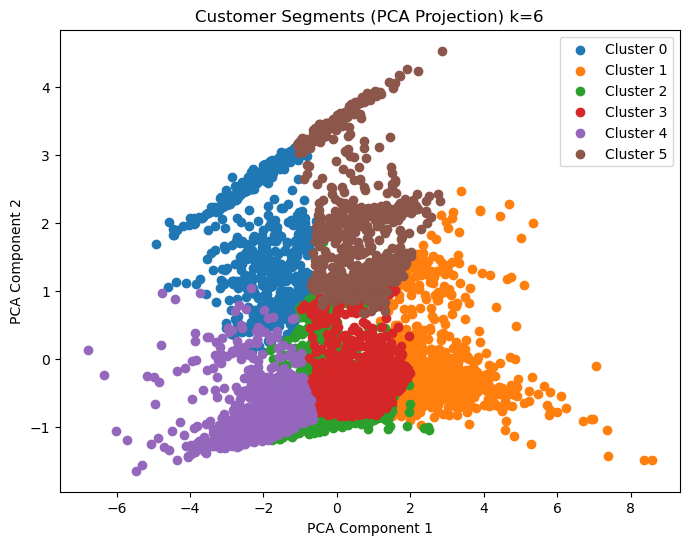

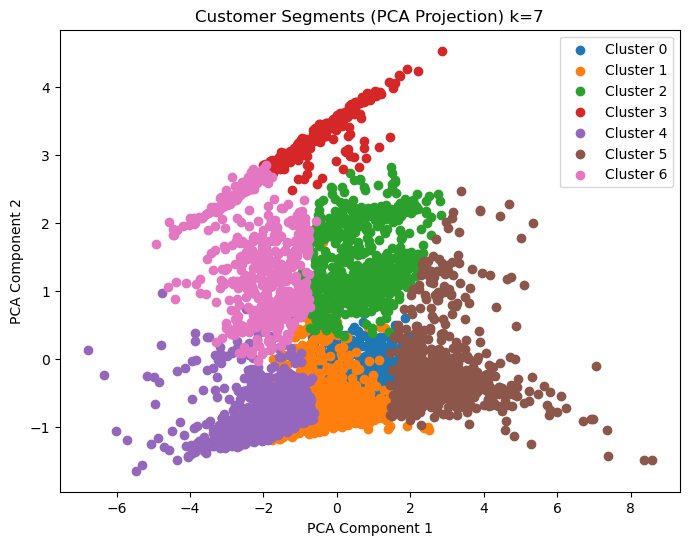

In [265]:
for k in range(2,8):
    k = k  
    kmeans = KMeans(n_clusters=k, random_state=25)
    labels = kmeans.fit_predict(rfm_expanded_scaled)
    
    # Reduce dimensions to 2 using PCA
    pca = PCA(n_components=2)
    rfm_pca = pca.fit_transform(rfm_expanded_scaled)
    
    # Scatter plot
    plt.figure(figsize=(8, 6))
    for cluster in range(k):
        plt.scatter(rfm_pca[labels == cluster, 0], rfm_pca[labels == cluster, 1], label=f'Cluster {cluster}')
    
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(f"Customer Segments (PCA Projection) k={k}")
    plt.legend()
    plt.show()

The silhouette_score confirms that  k=3 is optimal for the expanded dataset with k=2 being a close second. The clusters in this model are a little less defined than the with model 1.  The additional information muddies the definition of the segments.

## Takeaways from Model 1 and Model 2
With out input from management its hard to say which model is better.  Given that the top silhouette_scores for each model is .37 and .38 there is room for improvement in both.  It tells me that including all the rfm data and the expanded AOV and CLV do not provide the correct guidance and may need to be modified for better marketing purposes.

## Model 3 - Revenue and Spending-Based Segmentation

I will create a third model to be more specific in its goals.  This third model will focus on Revenue and Spending.  The thought is that we will be able to identify wholseale customers as big spending but lower frequency but still get insights into retail customers at the same time.

Model 3 will focus on three features:  CLV, AOV, and AOV / Frequency.  CLV will give a longer term indicator of spending.  AOV gives insight into high vs low spenders.  AOV / Frequency gives a better segmentation of customers spending habits by breaking high and low spenders into more definde categories based on purchase frequency.